In [1]:
import pandas as pd
import numpy as np
import os
import glob
import scipy.stats as stats

In [2]:
# Directory information
dir_ = 'dec/'
dir_list = os.listdir(dir_)

In [3]:
count = 0
for file in dir_list:
    if 'Store' in file:
        continue
    count += 1

Wideband Red = 0,
Wideband Green = 1,
Wideband Blue = 2,
RedEdge = 3,
Blue = 4,
NIR = 5,
Red = 6,
Green = 7

NONE = 0,
HOMOGENEITY = 1,
CONTRAST = 2,
ASM = 3,
MEAN_I = 4,
VAR_I = 5,
CORRELATION = 6

In [9]:
# Create a numpy array of all the features, with each row representing the feature vector of the features
channels = ['wideband_red', 'wideband_green', 'wideband_blue', 'red_edge', 'blue', 'nir', 'red', 'green']
features = ['none', 'homogeneity', 'contrast', 'asm', 'mean', 'var', 'correlation']
f_scores = {}

for channel in range(8):
    for feature in range(7):
        all_data = []
        species_name = []

        for i, file in enumerate(dir_list):
            if "Store"  in file:
                continue

            species_name.append(file.split('.')[0].split('_')[0].lower().replace(' ', '_')) 

            # Select feature
            data = np.load(dir_ + file, allow_pickle=True)
            data = data[:,:,channel,feature]
            data = data.reshape(-1, 1)
            all_data.append(np.mean(data))

        all_data = pd.DataFrame(all_data)
        all_data['species'] = species_name


        # Create ANOVA backbone table
        data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
        anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
        anova_table.set_index('Source of Variation', inplace = True)

        # calculate SSTR and update anova table
        x_bar = all_data[0].mean()
        SSTR = all_data.groupby('species').count() * (all_data.groupby('species').mean() - x_bar)**2
        anova_table['SS']['Between Groups'] = SSTR[0].sum()

        # calculate SSE and update anova table
        SSE = (all_data.groupby('species').count() - 1) * all_data.groupby('species').std()**2
        anova_table['SS']['Within Groups'] = SSE[0].sum()

        # calculate SSTR and update anova table
        SSTR = SSTR[0].sum() + SSE[0].sum()
        anova_table['SS']['Total'] = SSTR

        # update degree of freedom
        anova_table['df']['Between Groups'] = all_data['species'].nunique() - 1
        anova_table['df']['Within Groups'] = all_data.shape[0] - all_data['species'].nunique()
        anova_table['df']['Total'] = all_data.shape[0] - 1

        # calculate MS
        anova_table['MS'] = anova_table['SS'] / anova_table['df']

        # calculate F 
        F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
        anova_table['F']['Between Groups'] = F

        # p-value
        anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

        # F critical 
        alpha = 0.05
        # possible types "right-tailed, left-tailed, two-tailed"
        tail_hypothesis_type = "two-tailed"
        if tail_hypothesis_type == "two-tailed":
            alpha /= 2
        anova_table['F crit']['Between Groups'] = stats.f.ppf(1 - alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

        # Final ANOVA Table
        print()
        print(channels[channel], features[feature])
        print(anova_table)
        f_scores[channels[channel] + '_' + features[feature]] = anova_table['F']['Between Groups']


wideband_red none
                            SS  df          MS        F   P-value   F crit
Source of Variation                                                       
Between Groups        0.148933  18  0.00827407  1.49145  0.226372  2.87948
Within Groups        0.0776675  14  0.00554768                            
Total                 0.226601  32  0.00708127                            

wideband_red homogeneity
                             SS  df           MS        F     P-value   F crit
Source of Variation                                                           
Between Groups       0.00602088  18  0.000334493  4.06656  0.00533784  2.87948
Within Groups        0.00115157  14  8.22547e-05                              
Total                0.00717245  32  0.000224139                              

wideband_red contrast
                              SS  df           MS        F     P-value  \
Source of Variation                                                      
Between Groups


wideband_blue mean
                            SS  df          MS        F    P-value   F crit
Source of Variation                                                        
Between Groups        0.210784  18   0.0117102  3.02109  0.0204618  2.87948
Within Groups        0.0542662  14  0.00387615                             
Total                  0.26505  32  0.00828281                             

wideband_blue var
                              SS  df           MS       F     P-value   F crit
Source of Variation                                                           
Between Groups       0.000349826  18  1.94348e-05  4.9475  0.00201354  2.87948
Within Groups        5.49949e-05  14   3.9282e-06                             
Total                0.000404821  32  1.26507e-05                             

wideband_blue correlation
                              SS  df           MS        F      P-value  \
Source of Variation                                                       
Between G


nir contrast
                              SS  df           MS        F     P-value  \
Source of Variation                                                      
Between Groups        0.00104725  18  5.81807e-05  4.66564  0.00271354   
Within Groups        0.000174581  14    1.247e-05                        
Total                 0.00122183  32  3.81823e-05                        

                      F crit  
Source of Variation           
Between Groups       2.87948  
Within Groups                 
Total                         

nir asm
                              SS  df           MS        F      P-value  \
Source of Variation                                                       
Between Groups       3.15636e-05  18  1.75354e-06  6.26761  0.000573517   
Within Groups        3.91688e-06  14  2.79777e-07                         
Total                3.54805e-05  32  1.10877e-06                         

                      F crit  
Source of Variation           
Between Group

In [10]:
sorted(f_scores.items(), key=lambda x: x[1], reverse=True)

[('blue_var', 18.269162330426802),
 ('blue_contrast', 17.043867629079948),
 ('red_edge_asm', 8.5837925664204),
 ('wideband_blue_asm', 8.357132456338391),
 ('red_edge_homogeneity', 7.467462166852787),
 ('blue_correlation', 6.545008897086532),
 ('green_correlation', 6.52896858476438),
 ('wideband_blue_correlation', 6.493420957123),
 ('nir_asm', 6.267610232089046),
 ('red_correlation', 6.148619919876796),
 ('wideband_red_var', 5.347972493661666),
 ('wideband_blue_homogeneity', 5.299782756676226),
 ('wideband_green_var', 5.262512788175957),
 ('nir_homogeneity', 5.145716936932053),
 ('wideband_blue_contrast', 5.136354285048165),
 ('wideband_green_contrast', 5.136075852700917),
 ('wideband_red_contrast', 5.092579722139283),
 ('nir_var', 5.084589118906898),
 ('wideband_blue_var', 4.947498947156901),
 ('nir_contrast', 4.665640783232745),
 ('red_var', 4.655989415894555),
 ('wideband_red_correlation', 4.631640130771148),
 ('red_contrast', 4.563500909884911),
 ('red_edge_correlation', 4.293442682

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff21f151490>,
      dtype=object)

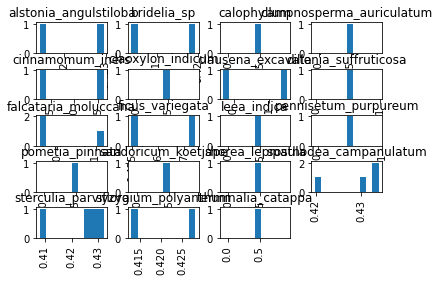

In [11]:
all_data[0].hist(by=all_data['species'])

In [8]:
all_data_

NameError: name 'all_data_' is not defined